# LIBRARIES IMPORT

In [1]:
# imports

import fig_lib 
import CNN_lib
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers, models


# DATA GENERATOR

In [2]:
# -------- DATA PARAMS --------

generate_new_data=True
video_d=False                            # Video = True , Image = False 
    
n_recs_train,n_recs_eval=400,100
height, width = 100, 100
circles_filled=False
color=255

# -------- Video ---------

n_frames=[10,15]    # [min,max]
t_btw_frm=0.2

In [3]:
#input_d, eval_d

if generate_new_data:

    if video_d:
        
        input_d=fig_lib.vid_data_gen(height, width,n_recs_train,n_frames,'I',cir_f=circles_filled,color=color)
        eval_d=fig_lib.vid_data_gen(height, width,n_recs_eval,n_frames,'I',cir_f=circles_filled,color=color)

    else:

        input_d=fig_lib.im_data_gen(height, width,n_recs_train,'I',cir_f=circles_filled,color=color)
        eval_d=fig_lib.im_data_gen(height, width,n_recs_eval,'I',cir_f=circles_filled,color=color)

In [4]:
print('RECORD - LABEL - SHAPE')

if generate_new_data:
    
    for R in input_d.keys():
        print(R,input_d[R]['label'],np.shape(input_d[R]['image']),type(input_d[R]['image']))

RECORD - LABEL - SHAPE
I0 circle (100, 100) <class 'numpy.ndarray'>
I1 circle (100, 100) <class 'numpy.ndarray'>
I2 line (100, 100) <class 'numpy.ndarray'>
I3 line (100, 100) <class 'numpy.ndarray'>
I4 line (100, 100) <class 'numpy.ndarray'>
I5 circle (100, 100) <class 'numpy.ndarray'>
I6 circle (100, 100) <class 'numpy.ndarray'>
I7 circle (100, 100) <class 'numpy.ndarray'>
I8 circle (100, 100) <class 'numpy.ndarray'>
I9 circle (100, 100) <class 'numpy.ndarray'>
I10 circle (100, 100) <class 'numpy.ndarray'>
I11 line (100, 100) <class 'numpy.ndarray'>
I12 circle (100, 100) <class 'numpy.ndarray'>
I13 line (100, 100) <class 'numpy.ndarray'>
I14 line (100, 100) <class 'numpy.ndarray'>
I15 circle (100, 100) <class 'numpy.ndarray'>
I16 circle (100, 100) <class 'numpy.ndarray'>
I17 line (100, 100) <class 'numpy.ndarray'>
I18 line (100, 100) <class 'numpy.ndarray'>
I19 line (100, 100) <class 'numpy.ndarray'>
I20 circle (100, 100) <class 'numpy.ndarray'>
I21 circle (100, 100) <class 'numpy.nda

circle


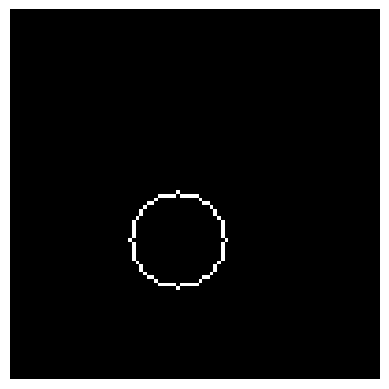

In [5]:
d_plt_check,rec_check=True,'I1'
print(input_d[rec_check]['label'])

if generate_new_data:

    if d_plt_check:

        if video_d:fig_lib.vid_show(input_d[rec_check]['image'],t_btw_frm=t_btw_frm)
        else:fig_lib.im_show(input_d[rec_check]['image'])


# CNN

### PARAMETERS

In [6]:
print('LIBRARY MODELS:')
print(' ')

for model_name in CNN_lib.MODELS.values(): print(model_name)

LIBRARY MODELS:
 
image_full
image_conv
image_conv_augmentation
video_conv2D


In [11]:
# -------- CNN PARAMS --------

# -------- MODEL --------

model_from_CNN_lib,mdl= False,'image_conv'

opt='adam'
lss='binary_crossentropy'

# -------- TRAINNING --------

epch=20


### GENERATE TRAIN DATA

In [8]:
# X_train,Y_train,X_eval,Y_eval

if video_d:
    
    X_train,Y_train,max_frm_n =CNN_lib.vid_d_bin_gen(input_d,height, width, zero='circle', one= 'line')
    X_eval,Y_eval,max_frm_n_eval =CNN_lib.vid_d_bin_gen(eval_d,height, width, zero='circle', one= 'line')

else:

    X_train,Y_train =CNN_lib.im_d_bin_gen(input_d,zero='circle', one= 'line')
    X_eval,Y_eval = CNN_lib.im_d_bin_gen(eval_d,zero='circle', one= 'line')

print('Train data:',len(Y_train),'Evaluation data:',len(Y_eval))

Train data: 400 Evaluation data: 100


 Train data shape: (400, 100, 100)  Validation data shape: (100, 100, 100)


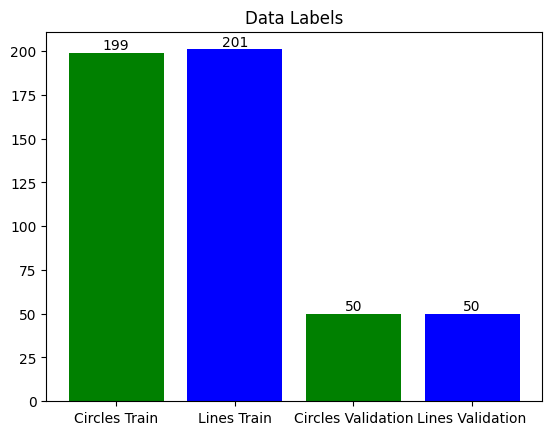

In [9]:
# check data

zeros_count = np.sum(Y_train == 0)
ones_count = np.sum(Y_train == 1)
zeros_count_val = np.sum(Y_eval == 0)
ones_count_val = np.sum(Y_eval == 1)

labels = ['Circles Train', 'Lines Train','Circles Validation', 'Lines Validation']
print(' Train data shape:', np.shape(X_train),' Validation data shape:', np.shape(X_eval))

plt.bar(labels, [zeros_count, ones_count,zeros_count_val,ones_count_val], color=['green', 'blue','green', 'blue'])

for i, count in enumerate([zeros_count, ones_count,zeros_count_val,ones_count_val]):

    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.title('Data Labels')
plt.show()

### MODEL

In [18]:
# MODEL 

if model_from_CNN_lib:
  
  if video_d: model = CNN_lib.lib_models(mdl,im_input_shp=(max_frm_n, height, width, 1))
  else: model = CNN_lib.lib_models(mdl,im_input_shp=(height, width))

else:

  model = models.Sequential([
                            layers.Rescaling(1./255, input_shape=(100, 100,1)),
                            layers.Conv2D(32, (3, 3), activation='relu'),
                            layers.MaxPooling2D((2, 2)),
                            layers.Conv2D(64, (3, 3), activation='relu'),
                            layers.MaxPooling2D((2, 2)),
                            layers.Conv2D(64, (3, 3), activation='relu'),
                            layers.MaxPooling2D((2, 2)),
                            layers.Dropout(0.2),
                            layers.Flatten(),
                            layers.Dense(64, activation='relu'),
                            layers.Dense(1, activation='sigmoid'),
                            ])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 100, 100, 1)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 49, 49, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 23, 23, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 21, 21, 64)       

In [ ]:
model.compile(optimizer=opt, loss=lss, metrics=['accuracy'])

### TRAINNING

In [ ]:
history =model.fit(X_train, Y_train, epochs=epch, validation_data=(X_eval,Y_eval))

### EVALUATE MODEL

In [ ]:
fg_size=(14,8)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epch)

plt.figure(figsize=fg_size)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')  
plt.ylabel('Accuracy')  

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')  
plt.ylabel('Loss')  
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(X_eval,Y_eval,verbose=2)

print(f'Loss: {test_loss}',f'Accuracy: {test_accuracy}')

### FORECAST

GENERATE RANDOM IMAGE

In [ ]:
# generate random im

n_rdm=np.random.rand()

if video_d:
    
    vd_ls=[]
    N_frames=np.random.randint(n_frames[0],n_frames[1]+1)

    if n_rdm>=0.5:

        p1=[np.random.randint(0, width-1),np.random.randint(0, height-1)]
        p2=[np.random.randint(0, width-1),np.random.randint(0, height-1)]

        for _ in range(N_frames):

            vd_ls.append(fig_lib.line_im(p1,p2,height=height, width=width,thickness=(1,3),color=color))
            p1[0]+= np.random.randint(-int(width*0.02), int(width*0.02))
            p2[0]+=np.random.randint(-int(width*0.06), int(width*0.06))
            p1[1]+= np.random.randint(-int(height*0.02), int(height*0.02))
            p2[1]+=np.random.randint(-int(height*0.06), int(height*0.06))

        label='Line'
        

    else:

        center= [np.random.randint(int(0+width*0.3), int(width - width*0.3)),np.random.randint(int(0+height*0.3), int(height-height*0.3))]
        radio = np.random.randint(12, 17)

        for _ in range(N_frames):
        
            vd_ls.append(fig_lib.circle_im(center,radio,height=height, width=width,thickness=(1,3),color=color,filled=circles_filled))
            center[0]+= np.random.randint(-int(width*0.03), int(width*0.03))
            center[1]+= np.random.randint(-int(height*0.03), int(height*0.03))
            radio += np.random.randint(-int(height*0.01), int(height*0.02))

        label ='circle'

    video=np.array(vd_ls)
    image = video[:, :, :, np.newaxis]
    frames_actual = image.shape[0]
    if frames_actual < max_frm_n:
        
        padding = np.zeros((max_frm_n - frames_actual, height, width, 1))
        image = np.concatenate([image, padding], axis=0)

else:

    if n_rdm>=0.5:

        p1=[np.random.randint(0, width-1),np.random.randint(0, height-1)]
        p2=[np.random.randint(0, width-1),np.random.randint(0, height-1)]
        image=fig_lib.line_im(p1,p2,height=height, width=width,thickness=(1,3),color=color)
        label='Line'

    else:
        
        center= [np.random.randint(int(0+width*0.3), int(width - width*0.3)),np.random.randint(int(0+height*0.3), int(height-height*0.3))]
        radio = np.random.randint(12, 17)
        image=fig_lib.circle_im(center,radio,height=height, width=width,thickness=(1,3),color=color,filled=circles_filled)
        label= 'circle'

In [ ]:
# Forecast

pred = model.predict(np.expand_dims(image, axis=0),verbose=2)
CNN_lib.bin_forecast(pred,label=label,up_frc='line',down_frc='circle')


In [ ]:
# show

if video_d:fig_lib.vid_show(video)
else:fig_lib.im_show(image)